Playing a bit with the data before writing a proper utils file.

TODO:
- add different types of ray sampling
- IDEA: A WAY TO CHECK IF PLUCKER EMBED IS CORRECT CAN BE BY COMPUTING THE CHANGES IN PLUCKER EMBEDDINGS AND COMPUTE THE K,P VALUES BACK AND SEE IF THEY CORRESPOND TO THAT OPERATION. This is for the augmentation part.

In [1]:
import os
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [2]:
def get_camera_params_for_file(filepath: str, w: int = 1, h: int = 1):
    """
    Parses camera parameters from a given RealEstate10K file.

    Args:
        filepath (str): Path for the txt file.
        w (int): Width of the video. Default is 1.
        h (int): Height of the video. Default is 1.

    Returns:
        tuple:
            - url (str): URL of the video.
            - K (torch.Tensor): 3x3 camera intrinsics matrix.
            - timestamps (np.ndarray): NumPy array of timestamps (in microseconds) for each frame.
            - extrinsics (torch.Tensor): [num_frames, 3, 4] Camera extrinsics matrices.
    """
    
    with open(filepath, 'r') as file:
        lines = file.readlines()
    # lines is a list of str representing lines from a file, containing
    # the video URL, timestamps, camera intrinsics, and extrinsics.
    
    # video URL
    url = lines[0].strip()
        
    # camera intrinsics (done just on first frame since it is constant across time)
    # normalized coordinates: top left corner of the image is (0, 0) and bottom right corner is (1, 1)
    first_frame = lines[1].strip().split()
    f_x, f_y, c_x, c_y = map(float, first_frame[1:5])
    K = torch.tensor([[w * f_x, 0,       w * c_x],
                      [0,       h * f_y, h * c_y],
                      [0,       0,       1]], dtype=torch.float32)
    
    
    # camera extrinsics and time
    timestamps = []
    extrinsics  = []
    for line in lines[1:]: # skip the first line (video URL)
        frame = line.strip().split()
        timestamp = int(frame[0])
        timestamps.append(timestamp)
        P = torch.tensor(list(map(float, frame[7:])), dtype=torch.float32).reshape(3, 4)
        extrinsics.append(P)
    
    return url, K, np.array(timestamps), torch.stack(extrinsics)

Videos have 16:9 resolution so let's say that we want an image of width $w$ and height $h$ we will have $16w\times 9h$. For now let's take one ray per pixel in this minimal resolution (i.e. 16 rays horizontally and 9 rays vertically (144 total rays)). We do this for efficiency for now, we can always scale it up if necessary.

In [3]:
def get_plucker_embedding(K_inv: torch.Tensor, P: torch.Tensor, num_rays_x: int = 16, num_rays_y: int = 9):
    """
    Computes Plücker ray embeddings (direction and moment) given camera intrinsics and extrinsics.

    Args:
        K_inv (torch.Tensor): 3x3 inverse intrinsic matrix.
        P (torch.Tensor): 3x4 extrinsic matrix.
        num_rays_x (int): Number of horizontal rays.
        num_rays_y (int): Number of vertical rays.

    Returns:
        tuple:
            - d (torch.Tensor): [num_rays, 3] direction vectors in world space.
            - m (torch.Tensor): [num_rays, 3] Plücker moments.
    """
    
    R, t = P[:, :3], P[:, 3]
    
    u = np.linspace(0, 1, num_rays_x, endpoint=False) + 0.5 / num_rays_x # ensure it's in the middle of the pixel
    v = np.linspace(0, 1, num_rays_y, endpoint=False) + 0.5 / num_rays_y 
    U, V = np.meshgrid(u, v)
    homogeneous_uv = np.vstack([U.flatten(), V.flatten(), np.ones_like(U.flatten())]) # [3, num_rays] where num_rays = num_rays_x * num_rays_y 
    # 0 contains the x coordinates, 1 contains the y coordinates, 2 contains the z coordinates (all 1s)
    # so homogeneous_uv[:, i] is [u_i, v_i, 1]
    
    # ray direction d = R^T * K^-1 * [u, v, 1]^T
    # K_inv = torch.linalg.inv(K)
    d = R.T @ K_inv @ torch.tensor(homogeneous_uv, dtype=torch.float32, device=K_inv.device) # [3, num rays]
    d = d / torch.norm(d, dim=0, keepdim=True) 
    d = d.T # [num_rays, 3] (each row is a direction vector)
    
    # ray origins (camera center in world coordinate)
    camera_center = - R.T @ t # [3]
    O = camera_center.expand(d.shape[0], -1) # [num_rays, 3]
    
    # ray moment m = o x d
    m = torch.cross(O, d, dim=1) # [num_rays, 3]
    # PS: since ||d||=1, then ||m||=distance from ray to origin
    
    return d, m

# Example 

In [4]:
file_path = "../RealEstate10K/RealEstate10K/train/0000cc6d8b108390.txt"

url, K, timesteps, extrinsics = get_camera_params_for_file(file_path)
frame_idx = 0
P = extrinsics[frame_idx]

In [5]:
print(f"URL: {url}")
print(f"K shape: {K.shape}\nK: {K}")
print(f"Number of frames shape: {len(timesteps)}\nMicroseconds since start of video: {timesteps[:5]} etc...")
print(f"Frame {frame_idx} --> P shape: {P.shape}\nP: {P}")

URL: https://www.youtube.com/watch?v=KeXr_qWVbiU
K shape: torch.Size([3, 3])
K: tensor([[0.5110, 0.0000, 0.5000],
        [0.0000, 0.9084, 0.5000],
        [0.0000, 0.0000, 1.0000]])
Number of frames shape: 218
Microseconds since start of video: [52553000 52586000 52619000 52653000 52686000] etc...
Frame 0 --> P shape: torch.Size([3, 4])
P: tensor([[ 0.9999,  0.0044, -0.0106, -0.1363],
        [-0.0043,  1.0000,  0.0030,  0.0233],
        [ 0.0107, -0.0029,  0.9999, -0.3366]])


In [6]:
K_inv = torch.linalg.inv(K)
num_rays_x, num_rays_y = 16, 9
num_rays = num_rays_x * num_rays_y
ray_directions, plucker_moments = get_plucker_embedding(K_inv, P, num_rays_x, num_rays_y)
print(f"Total number of rays: {num_rays}")
print(f"ray_directions shape: {ray_directions.shape}")
print(f"plucker_moments shape: {plucker_moments.shape}")
ray_idx = np.random.randint(0, num_rays)
print(f"Example of (d, m) in a random ray: d={ray_directions[ray_idx]}, m={plucker_moments[ray_idx]}")

Total number of rays: 144
ray_directions shape: torch.Size([144, 3])
plucker_moments shape: torch.Size([144, 3])
Example of (d, m) in a random ray: d=tensor([0.3808, 0.3187, 0.8680]), m=tensor([-0.1273,  0.0061,  0.0536])


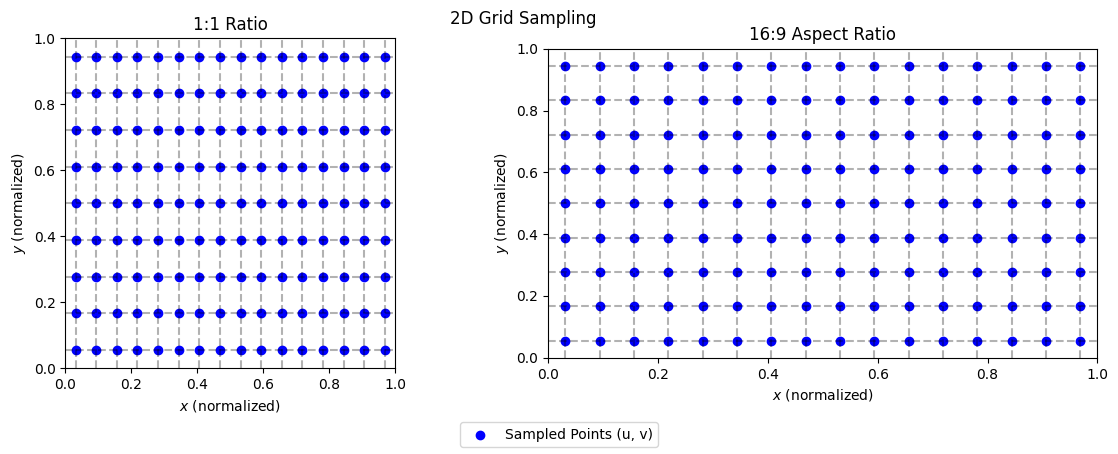

In [7]:
u = np.linspace(0, 1, num_rays_x, endpoint=False) + 0.5 / num_rays_x
v = np.linspace(0, 1, num_rays_y, endpoint=False) + 0.5 / num_rays_y
U, V = np.meshgrid(u, v)
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# 1:1 plot
sc1 = axs[0].scatter(U, V, color='blue', label='Sampled Points (u, v)')
for i in range(num_rays_x):
    axs[0].plot([u[i], u[i]], [0, 1], 'k--', alpha=0.3)  # Vertical lines
for j in range(num_rays_y):
    axs[0].plot([0, 1], [v[j], v[j]], 'k--', alpha=0.3)  # Horizontal lines
axs[0].set_xlabel("$x$ (normalized)")
axs[0].set_ylabel("$y$ (normalized)")
axs[0].set_title("1:1 Ratio")
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].set_aspect('equal')  # Normalized square aspect ratio

# 16:9 plot
sc2 = axs[1].scatter(U, V, color='blue', label='Sampled Points (u, v)')
for i in range(num_rays_x):
    axs[1].plot([u[i], u[i]], [0, 1], 'k--', alpha=0.3)  # Vertical lines
for j in range(num_rays_y):
    axs[1].plot([0, 1], [v[j], v[j]], 'k--', alpha=0.3)  # Horizontal lines
axs[1].set_xlabel("$x$ (normalized)")
axs[1].set_ylabel("$y$ (normalized)")
axs[1].set_title("16:9 Aspect Ratio")
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_aspect(9/16)  # True 16:9 aspect ratio

fig.legend(handles=[sc1], labels=['Sampled Points (u, v)'], loc='lower center', ncol=1) # Create a single legend for the figure
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make space for legend at the bottom
plt.suptitle("2D Grid Sampling")
plt.show()

In [8]:
show_3d_plot = False
if show_3d_plot:
    import plotly.graph_objects as go 
    
    # Extract camera center (origin) for visualization
    R, t = P[:, :3], P[:, 3]
    camera_center = (-R.T @ t).numpy()
    ray_dirs_np = ray_directions.numpy()

    # Create figure
    fig = go.Figure()
    # Add camera center
    fig.add_trace(go.Scatter3d(
        x=[camera_center[0]], y=[camera_center[1]], z=[camera_center[2]],
        mode='markers', marker=dict(size=6, color='red'),
        name='Camera Center'
    ))
    # Add rays as lines
    for i in range(ray_dirs_np.shape[0]):
        d = ray_dirs_np[i]
        fig.add_trace(go.Scatter3d(
            x=[camera_center[0], camera_center[0] + d[0]],
            y=[camera_center[1], camera_center[1] + d[1]],
            z=[camera_center[2], camera_center[2] + d[2]],
            mode='lines', line=dict(color='blue', width=2),
            opacity=0.6
        ))

    # Layout adjustments
    fig.update_layout(
        title="Interactive 3D Visualization of Rays (16x9)",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode='auto'
        ),
        showlegend=False
    )

    fig.show()

In [9]:
def parse_directory(directory: str, w: int = 1, h: int = 1, num_rays_x: int = 16, num_rays_y: int = 9):
    """
    Parses all RealEstate10K files in a given directory and computes Plücker embeddings.

    Args:
        directory (str): Path for the directory containing txt files.
        num_rays_x (int): Number of horizontal rays.
        num_rays_y (int): Number of vertical rays.
        w (int): Width of the videos. Default is 1.
        h (int): Height of the videos. Default is 1.

    Returns:
        list: A list of dictionaries where each entry contains:
            - "url": (str) Video URL.
            - "K": (torch.Tensor) [3,3] Intrinsic matrix.
            - "timestamps": (np.ndarray) Frame timestamps.
            - "extrinsics": (torch.Tensor) [num_frames, 3, 4] Camera extrinsics.
            - "directions": (torch.Tensor) [num_frames, num_rays, 3] Ray directions.
            - "moments": (torch.Tensor) [num_frames, num_rays, 3] Plücker moments.
    """
    
    camera_data = []
    txt_files = [file for file in os.listdir(directory) if file.endswith(".txt")]
    
    for txt_file in tqdm(txt_files, desc="Processing RealEstate10K files", unit="file"):
        filepath = os.path.join(directory, txt_file)
        
        video_url, K, timestamps, extrinsics = get_camera_params_for_file(filepath, w, h)
        
        K_inv = torch.linalg.inv(K)
        num_frames = extrinsics.shape[0]
        num_rays = num_rays_x * num_rays_y
        ray_directions = torch.zeros((num_frames, num_rays, 3), dtype=torch.float32, device=K_inv.device)
        plucker_moments = torch.zeros((num_frames, num_rays, 3), dtype=torch.float32, device=K_inv.device)
        for i in range(num_frames):
            d, m = get_plucker_embedding(K_inv, extrinsics[i], num_rays_x, num_rays_y)
            ray_directions[i] = d
            plucker_moments[i] = m

        camera_data.append({
            "url": video_url,
            "K" : K, 
            "timestamps": timestamps,
            "extrinsics": extrinsics,
            "directions": ray_directions,
            "moments": plucker_moments
        })

    return camera_data

In [ ]:
def save_data(data, filename="camera_data.pkl"):
    """
    Saves the parsed camera data to a file using pickle.

    Args:
        data (list): List of dictionaries containing camera data.
        filename (str): Name of the file to save the data.
    """
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"Data successfully saved to {filename}")

def load_data(filename="camera_data.pkl"):
    """
    Loads the parsed camera data from a file.

    Args:
        filename (str): Name of the file to load the data from.

    Returns:
        list: List of dictionaries containing camera data.
    """
    with open(filename, "rb") as f:
        data = pickle.load(f)
    print(f"Data successfully loaded from {filename}")
    return data

In [ ]:
# TODO
test_data = parse_directory("../RealEstate10K/RealEstate10K/test")
save_data(test_data, "test.pkl")
# loaded_data = load_data("test.pkl")

In [ ]:
train_data = parse_directory("../RealEstate10K/RealEstate10K/train")
save_data(train_data, "train.pkl")